## Imports

In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from os import listdir
from os.path import isfile, join

## Some initial config

In [225]:
INPUT_DIMS = [256,256]
BIN_DTYPE = 'int16'
PATH = "../Images/bin/"
SAMPLE = None

## Generate label DataFrame

In [226]:
liver_images = np.array([f for f in listdir(PATH) if isfile(join(PATH, f))])
#print(f"Number of liver image files: {len(liver_images)}")
cancer_types = np.array([f.split('_')[0] for f in liver_images])
patient_numbers = np.array([int(f.split('_')[1]) for f in liver_images])
slice_numbers = np.array([int(f.split('_')[2].split('.')[0]) for f in liver_images])

ldata = {'filename' : liver_images, 
         'cancer_type' : cancer_types, 
         'image_id' : patient_numbers, 
         'slice_number' : slice_numbers}

image_labels = pd.DataFrame(data=ldata).sort_values(['cancer_type','image_id','slice_number'],
                                                   ignore_index=True)
image_labels.head()
if SAMPLE:
    image_labels = image_labels.sample(SAMPLE)

### Display some sample images

In [227]:
def get_image(fpath,d_type=BIN_DTYPE,dims=INPUT_DIMS):
    '''
    Returns a numpy array given a .bin file path and
    image dimensionality
    
    Parameters
        fpath: file path to .bin file
        d_type: data type of .bin file
        dims: image dimensionality
    Returns
        image: numpy array from bin file data
    '''
    image = np.reshape(np.fromfile(fpath,d_type),dims)
    return image

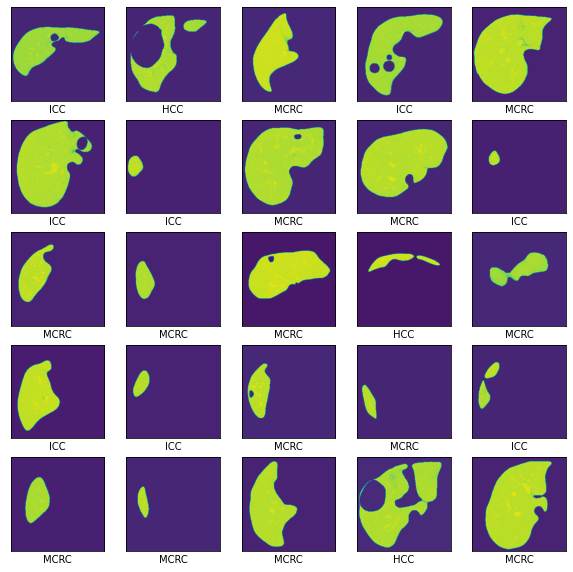

In [228]:
sample_labels = image_labels.sample(25)


plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    img = get_image(PATH+sample_labels.filename.iloc[i])
    ctype = sample_labels.cancer_type.iloc[i]
    plt.imshow(img)
    plt.xlabel(ctype)
plt.show()

## Split Data into training and testing sets

In [229]:
#split df into cancer types
HCC_labels = image_labels.loc[image_labels.cancer_type == 'HCC']
ICC_labels = image_labels.loc[image_labels.cancer_type == 'ICC']
MCRC_labels = image_labels.loc[image_labels.cancer_type == 'MCRC']
print(f"{len(HCC_labels)} HCC images found")
print(f"{len(ICC_labels)} ICC images found")
print(f"{len(MCRC_labels)} MCRC images found")

5974 HCC images found
13140 ICC images found
9482 MCRC images found


In [230]:
from sklearn.model_selection import train_test_split

train_rows, test_rows = train_test_split(image_labels, test_size=0.2)

In [231]:
# dict to map cancer types to numerical classes
c_class = {'HCC':0,
          'ICC':1,
          'MCRC':2}

In [232]:
#preallocate training data array
n_train = len(train_rows)
train_images = np.zeros([n_train]+INPUT_DIMS,dtype=BIN_DTYPE)

for i in range(n_train):
    print(f"{i+1}/{n_train}", end='\r')
    train_images[i,:,:]=get_image(PATH+train_rows.filename.iloc[i])

train_labels = np.array([[c_class[c]] for c in train_rows.cancer_type.tolist()])

In [233]:
#preallocate testing data array
n_test = len(test_rows)
test_images = np.zeros([n_test]+INPUT_DIMS,dtype=BIN_DTYPE)

for i in range(n_test):
    print(f"{i+1}/{n_test}", end='\r')
    test_images[i,:,:]=get_image(PATH+test_rows.filename.iloc[i])

test_labels = np.array([[c_class[c]] for c in test_rows.cancer_type.tolist()])

## Create Convolutional Base

In [234]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256,1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [235]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 60, 60, 64)        36928     
                                                                 
Total params: 55,744
Trainable params: 55,744
Non-trai

In [236]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 60, 60, 64)        36928     
                                                                 
 flatten_5 (Flatten)         (None, 230400)           

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
 35/715 [>.............................] - ETA: 11:29 - loss: 437.9543 - accuracy: 0.3938

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print(test_acc)